# KC House Data
## 0.0 Business case
The estate market is complex and highly competitive. There are a lot of buyers motivated by a wide range of reasons. As the demand is high, the tools/services available to assist people on the market are a plethora. Although there are a lot of eyes scrutinising the estate market, we feel there is still a lot of opportunities laying around.

We are a company working for property developers. We aim to maximise their return on investment on a short-term to medium-term basis. We have access to a county-wide database and, with the help of data science and market analysis techniques, we can highlight areas and properties with high potential. Our primary focus is on underpriced properties and regions with recent higher growth.
## 0.1 Importing libraries and global settings

In [86]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

##############################
# notebook parameters

# import warnings
# warnings.filterwarnings('ignore')
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
sns.set(rc={'figure.figsize':(12,9)})

## 1. Exploratory Data Analysis

In [87]:
kc = pd.read_csv('./source/kc_house_data.csv', parse_dates=[1,14])

In [88]:
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955-01-01,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951-01-01,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933-01-01,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965-01-01,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987-01-01,0.0,98074,47.6168,-122.045,1800,7503


In [89]:
kc.describe(include='all')

<ipython-input-89-f26630f63f73>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  kc.describe(include='all')
<ipython-input-89-f26630f63f73>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  kc.describe(include='all')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,...,21597.000000,21597.000000,21597,21597,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
unique,NaN,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,304,116,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2014-06-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,2014-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12826,559,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2014-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1900-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-05-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,4.580474e+09,NaN,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,...,7.657915,1788.596842,NaN,NaN,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,NaN,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,...,1.173200,827.759761,NaN,NaN,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,NaN,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,...,3.000000,370.000000,NaN,NaN,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,NaN,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,NaN,NaN,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000


In [90]:
kc[kc['yr_renovated']==0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955-01-01,0.0,98178,47.5112,-122.257,1340,5650
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965-01-01,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987-01-01,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,2014-05-12,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001-01-01,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995-01-01,0.0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,...,8,1530,0.0,2009-01-01,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,...,8,2310,0.0,2014-01-01,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,...,7,1020,0.0,2009-01-01,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,...,8,1600,0.0,2004-01-01,0.0,98027,47.5345,-122.069,1410,1287


Some properties have gone through a renovation process. It is interesting to see that, out of the 21597 properties available in the dataset, 17011 of those were not renovated. 78% is a surprisingly high ratio, and it probably reflects an imperfect collection of data or only the renovations requiring a permit were recorded (substantial/structural home improvement).

It is worth examining this parameter as a considerate home improvement can drastically improve the value of a property in a short amount of time.

In [91]:
kc[kc['sqft_basement']=='?']

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6,1321400060,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995-01-01,0.0,98003,47.3097,-122.327,2238,6819
18,16000397,2014-12-05,189000.0,2,1.00,1200,9850,1.0,0.0,0.0,...,7,1200,?,1921-01-01,0.0,98002,47.3089,-122.210,1060,5095
42,7203220400,2014-07-07,861990.0,5,2.75,3595,5639,2.0,0.0,0.0,...,9,3595,?,2014-01-01,0.0,98053,47.6848,-122.016,3625,5639
79,1531000030,2015-03-23,720000.0,4,2.50,3450,39683,2.0,0.0,0.0,...,10,3450,?,2002-01-01,0.0,98010,47.3420,-122.025,3350,39750
112,2525310310,2014-09-16,272500.0,3,1.75,1540,12600,1.0,0.0,0.0,...,7,1160,?,1980-01-01,0.0,98038,47.3624,-122.031,1540,11656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21442,3226049565,2014-07-11,504600.0,5,3.00,2360,5000,1.0,0.0,0.0,...,7,1390,?,2008-01-01,0.0,98103,47.6931,-122.330,2180,5009
21447,1760650900,2014-07-21,337500.0,4,2.50,2330,4907,2.0,0.0,0.0,...,7,2330,?,2013-01-01,NaN,98042,47.3590,-122.081,2300,3836
21473,6021503707,2015-01-20,352500.0,2,2.50,980,1010,3.0,NaN,0.0,...,8,980,?,2008-01-01,0.0,98117,47.6844,-122.387,980,1023
21519,2909310100,2014-10-15,332000.0,4,2.50,2380,5737,2.0,0.0,0.0,...,7,2380,?,2010-01-01,0.0,98023,47.2815,-122.356,2380,5396


In [92]:
kc.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

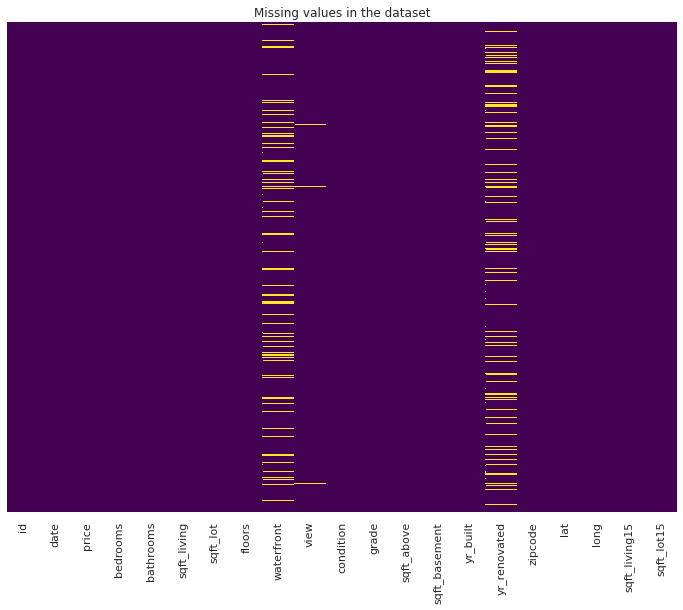

In [93]:
sns.heatmap(kc.isnull(), yticklabels=False, cbar=False, cmap='viridis');
plt.title('Missing values in the dataset');

As the preliminary analysis suggests, there are a few data issues that need addressing:

* `waterfront`, although has 2376 NA values, is too complex to be filled in (and won't be used during the rest of the analysis). We will leave the field as is.
* `views` has 63 NA that we are going to replace with 0.
* `yr_renovated` has 17011 zero-values, it will be changed to NaN
* a property has 33 bedrooms, we think 3 is more likely
* `sqft_basement` had 454 '?' values, they will be changed to 0.
* In case we need to track something down, we are also going to generate a dictionary of the properties we have modified during this analysis: `properties_data_altered` {key = 'property ID', value = 'altered field'}

In [94]:
# sqft_basement
properties_data_altered = {}
for i in range(0,len(kc['id'])-1):
        if kc['sqft_basement'][i] == '?':
            kc['sqft_basement'][i] = 0
        properties_data_altered[kc['id'][i]] = 'sqft_basement'

# 33 bedrooms house
properties_data_altered[kc[kc['bedrooms']==33].iloc[0]['id']] = '33_bedrooms'
kc['bedrooms'] = kc['bedrooms'].replace(33,3)

# view
for i in kc[kc['view'].isnull()]['id']:
    properties_data_altered[i] = 'views'
kc['view'] = kc['view'].fillna(0)

# yr_renovated
for i in kc[kc['yr_renovated']=='0.0']['id']:
    properties_data_altered[i] = 'yr_renovated'
kc['yr_renovated'] = kc['yr_renovated'].replace('0.0', np.nan)

<ipython-input-94-46342bf02129>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc['sqft_basement'][i] = 0


Some fields have the wrong data type, let's fix this:
(note that fields such as bathrooms/bedrooms shouldn't be continuous but we are keeping them as such to allow for linear regression)

In [95]:
# lines are commented to allow us to work on non categorised data
kc['id'] = kc['id'].astype(str)
# kc['bathrooms'] = kc['bathrooms'].astype(str)
# kc['bedrooms'] = kc['bedrooms'].astype(str)
# kc['condition'] = kc['condition'].astype(str)
# kc['floors'] = kc['floors'].astype(str)
# kc['grade'] = kc['grade'].astype(str)
kc['sqft_basement'] = kc['sqft_basement'].astype(float)
# kc['view'] = kc['view'].astype(str)
kc['waterfront'] = kc['waterfront'].astype(str)
kc['yr_renovated'] = pd.to_datetime(kc['yr_renovated'])
kc['zipcode'] = kc['zipcode'].astype(str)

### 1.1 Generating the subdatasets

In [101]:
duplicate_properties = kc[kc.duplicated(['id'], keep=False)].reset_index(drop=True)
kc = kc.sort_values('date').drop_duplicates('id', keep='last')

In [107]:
# A house has been sold 3 times during the time interval.
# Lets's drop the middle date to cover the whole price evolution

duplicate_properties.drop(duplicate_properties.index[317], inplace=True)

In [108]:
duplicate_properties['time_diff'] = duplicate_properties['date'].diff()
duplicate_properties['price_diff'] = duplicate_properties['price'].diff()
duplicate_properties['rate_of_price_increase'] = duplicate_properties['price_diff'] / pd.to_numeric(duplicate_properties['time_diff'])

In [115]:
value_loss=[]
for i in range(len(duplicate_properties)):
    if i % 2 == 1:
        try:
            if duplicate_properties['price'][i] - duplicate_properties['price'][i-1] < 0:
                value_loss.append(i)
        except KeyError:
            pass
print(len(value_loss))
value_loss

17


[15,
 85,
 119,
 183,
 237,
 275,
 321,
 323,
 325,
 329,
 331,
 335,
 337,
 339,
 341,
 345,
 349]

In [118]:
sorted([duplicate_properties['zipcode'][i] for i in value_loss])

['98006',
 '98006',
 '98007',
 '98010',
 '98027',
 '98033',
 '98053',
 '98075',
 '98107',
 '98117',
 '98118',
 '98118',
 '98118',
 '98125',
 '98133',
 '98166',
 '98178']

Some properties (17) have lost value over time. At first sight, there doesn't seem to be any geographical reason for this depreciation.

## 2. Analysing the market growth based on properties with mutliple entries

In [83]:
##############################
# Insert columns and sets the type

duplicate_properties.insert(2,"time_diff",0)
duplicate_properties.insert(4,"price_diff",0)
duplicate_properties.insert(5,"rate_of_price_increase",0)
duplicate_properties["date"] = pd.to_datetime(duplicate_properties['date'])
duplicate_properties["time_diff"] = pd.to_datetime(duplicate_properties['time_diff'])

##############################
# reset the index and dropping the middle value of the property sold 3 times during timeframe

duplicate_properties = duplicate_properties.reset_index()
duplicate_properties = duplicate_properties.drop("index", 1)
duplicate_properties = duplicate_properties.drop(317)
duplicate_properties = duplicate_properties.reset_index()
duplicate_properties = duplicate_properties.drop("index", 1)

##############################
# calculate the price increase and the time spent between sales

duplicate_properties['time_diff'] = duplicate_properties.groupby(['id'])['date'].shift(1) #run a lag operation on dates
duplicate_properties['price_diff'] = duplicate_properties.groupby(['id'])['price'].shift(1) #run a lag operation on prices
duplicate_properties["time_diff"] = duplicate_properties['date'] - duplicate_properties['time_diff'] #get the date difference and add it to 'time_diff' column
duplicate_properties["price_diff"] = duplicate_properties['price'] - duplicate_properties['price_diff'] #get the price difference and add it to 'price_diff' column
analysis_df = duplicate_properties.copy()

for row in range(0,len(analysis_df),2):
     analysis_df.drop(index=row,inplace=True)
        
analysis_df.insert(3,"time_diff_seconds",0) #add a column for time difference as an int
analysis_df["time_diff_seconds"] = pd.to_numeric(analysis_df["time_diff"])/1000000000 #convert timedelta obeject to seconds (stored as ns by default)
analysis_df["rate_of_price_increase"] = analysis_df["price_diff"]/(analysis_df["time_diff_seconds"]/86400) #calculate rate of increase in prices

##############################
# create a dataframe to generate the graph

hot_zip_codes = analysis_df.groupby(["zipcode"])["rate_of_price_increase"].mean() #create a Pandas series of rate of the mean rate of price inrease grouped by zip code
hot_zip_codes = analysis_df.groupby(["zipcode"]).mean() #group everything by zipcode and take the mean
hot_zip_codes_count = analysis_df.groupby(["zipcode"]).count() #group everything by zipcode and run a count
hot_zip_codes.drop(columns = ["time_diff_seconds", "price", "price_diff", "bedrooms", "bathrooms"],inplace = True) #remove extranous columns
hot_zip_codes.drop(columns = ["sqft_living", "sqft_lot", "floors", "view", "condition"],inplace = True) #remove extranous columns
hot_zip_codes.drop(columns = ["grade", "sqft_above", "sqft_living15", "sqft_lot15"],inplace = True) #remove extranous columns
hot_zip_codes.sort_values(ascending = False, inplace = True, by="rate_of_price_increase")  #sort hot zip codes in descending order
hot_zip_codes.reset_index(level=0, inplace=True)
hot_zip_codes = hot_zip_codes.sort_values(['rate_of_price_increase']).reset_index(drop=True)
y_axis = [
    '98034', '98155', '98126', '98117', '98011', '98177', '98148', '98007', '98199', '98118', '98042', 
    '98074', '98115', '98032', '98133', '98116', '98052', '98028', '98055', '98103', '98122', '98106', 
    '98072', '98059', '98053', '98003', '98031', '98004', '98144', '98198', '98125', '98030', '98039', 
    '98178', '98045', '98001', '98056', '98146', '98107', '98166', '98070', '98168', '98006', '98024', 
    '98038', '98023', '98188', '98058', '98112', '98002', '98108', '98065', '98075', '98077', '98014', 
    '98029', '98027', '98033', '98010'
         ]

##############################
# generate the graph

plt.figure(figsize=(20,10))
chart = sns.barplot(x = "zipcode", 
                    y = "rate_of_price_increase", 
                    data = hot_zip_codes, 
                    order = y_axis)

chart.set_xticklabels(chart.get_xticklabels(), 
                      rotation=45, 
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large');

KeyError: '[317] not found in axis'

### 2.1 Mapping of zipcodes growth

In [ ]:
hot_zip_codes

In [ ]:
kc_zip_mean = kc.groupby('zipcode').aggregate(np.mean)
kc_zip_mean.drop(['lat', 'long'], axis=1, inplace=True)
kc_zip_mean.reset_index(inplace = True)

map_kc = gpd.read_file('source/Zip_Codes/Zip_Codes.shp')
map_kc['zipcode'] = map_kc['ZIPCODE']
map_kc.drop(['ZIP', 'ZIPCODE', 'OBJECTID'], axis=1, inplace=True)
merged = pd.merge(map_kc, kc_zip_mean, on='zipcode')

# hot_zip_codes.reset_index(inplace=True)
hot_zip_codes['zipcode']=hot_zip_codes['zipcode'].astype(str)
# hot_zip_codes.drop(['lat', 'long'], axis=1, inplace=True)
appended_data = []

for zipcode in list(kc['zipcode'].unique()):
    if zipcode not in list(hot_zip_codes['zipcode']):
        appended_data.append({'zipcode':zipcode, 'rate_of_price_increase':0})
        
appended_df = pd.DataFrame(data=appended_data)

merged_df = pd.concat([hot_zip_codes, appended_df], axis=0)

merged_df['zipcode'].nunique()

merged_2 = pd.merge(merged, merged_df, on='zipcode')
gdf=gpd.GeoDataFrame(merged_2, geometry=merged_2.geometry)

gdf.plot(column='rate_of_price_increase', k=5, colormap='OrRd', legend=True, figsize=(20,12))
plt.show()

## 3. Seasonality

In [ ]:
# our area of focus, based on the price evolution analysed in kc_duplicated and their geographical location
focus_zipcodes = [
    '98034','98011','98028','98155','98133','98177','98125','98115','98103','98117','98107','98199'
]

# our main dataset
kayCee = kc[kc['zipcode'].isin(focus_zipcodes)] # 4905 houses

In [ ]:
##############################
# generate a dataset to analyse the seasonality of data

seasonality_df = kc.copy() #copy main data
seasonality_df.insert(3,"month",0) #add a column for time month
seasonality_df.insert(4,"year",0) #add a column for time year
seasonality_df["date"] = pd.to_datetime(seasonality_df['date']) #convert date column to datetime objects from object
seasonality_df["month"] = seasonality_df["date"].dt.month #extract month
seasonality_df["year"] = seasonality_df["date"].dt.year #extract year
per_month = seasonality_df.set_index('date').groupby(pd.Grouper(freq='M'))['id'].count() #create a Pandas series with the values we need

##############################
# generate the seasonality graph

plt.figure(figsize=(20,10)) 
chart = sns.barplot(
                    x = per_month.index, 
                    y = per_month.values
                   )
xlabels = ['2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05']
chart.set_xlabel('Time of the year')
chart.set_ylabel('Houses sold');

chart.set_xticklabels(xlabels,
                      rotation=45, 
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large');

## 4. Renovations
### 4.1 Non-renovated development within the hot zone
Non renovated properties are generally cheaper than renovated ones.

The properties showing the highest potential return are the ones in poor conditions (1 and 2). If brought to condition 3 would on average sell for 542,000 (condition 1 to 3, 3 bedrooms).

In [ ]:
no_renovation = kayCee[kayCee.yr_renovated=='1970-01-01 00:00:00.000000000']

no_renovation_1 = no_renovation[no_renovation.condition==1] # 4 properties
no_renovation_1.price.min() # 125,000
no_renovation_1.price.median() # 233,000
no_renovation_1.price.max() # 352,950

no_renovation_2 = no_renovation[no_renovation.condition==2] # 19 properties
no_renovation_2.price.min() # 237,000
no_renovation_2.price.median() # 420,550
no_renovation_2.price.max() # 975,000

no_renovation_3 = no_renovation[no_renovation.condition==3] # 2384 properties
no_renovation_3.price.min() # 130,000
no_renovation_3.price.median() # 465,000
no_renovation_3.price.max() # 4,500,000

no_renovation_4 = no_renovation[no_renovation.condition==4] # 969 properties
no_renovation_4.price.min() # 195,000
no_renovation_4.price.median() # 476,000
no_renovation_4.price.max() # 3,070,000

no_renovation_5 = no_renovation[no_renovation.condition==5] # 410 properties
no_renovation_5.price.min() # 238,000
no_renovation_5.price.median() # 570,000
no_renovation_5.price.max() # 3,000,000

### 4.2 Renovated development within the hot zone
For properties already renovated, the price tag is slightly higher but some properties still have a high profit potential; the renovated_1 property could yield 33% - minus renovation costs - if brought to a condition 3 (compared to the average price of 2 bedrooms house)

In [ ]:
renovated = kayCee[kayCee.yr_renovated!='1970-01-01 00:00:00.000000000']

renovated_1 = renovated[renovated.condition==1] # 1 property
renovated_1.price.min() # 305,000
renovated_1.price.median() # 305,000
renovated_1.price.max() # 305,000

renovated_2 = renovated[renovated.condition==2] # 2 properties
renovated_2.price.min() # 400,000
renovated_2.price.median() # 524,975
renovated_2.price.max() # 649,950

renovated_3 = renovated[renovated.condition==3] # 744 properties
renovated_3.price.min() # 90,000
renovated_3.price.median() # 499,000
renovated_3.price.max() # 3,200,000

renovated_4 = renovated[renovated.condition==4] # 273 properties
renovated_4.price.min() # 230,000
renovated_4.price.median() # 483,000
renovated_4.price.max() # 2,230,000

renovated_5 = renovated[renovated.condition==5] # 99 properties
renovated_5.price.min() # 291,500
renovated_5.price.median() # 625,000
renovated_5.price.max() # 1,580,000

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot('sqft_living', 'price', data=no_renovation_3[no_renovation_3.bedrooms==2], hue='grade')
plt.title('2 bedrooms properties no yet renovated, in a condition 3')
y_average = renovated[renovated['bedrooms']==2]['price'].mean()
# ax.axhline(y_average, ls='--');
# plt.xlim(0,5000)
# plt.ylim(0,2500000)

## 5. Statistical Model

In [ ]:
##############################
# generate dataframes

hot_zipcodes_list = ['98034','98011','98028','98155','98133','98177', 
                     '98125','98115','98103','98117','98107','98199']
kc_hot_zipcodes = kc[kc.zipcode.isin(hot_zipcodes_list)]
kc_not_hot_zipcodes = kc[~kc.zipcode.isin(hot_zipcodes_list)]

### 5.1 Model for the hot Zipcodes

In [ ]:
##############################
# scale the variables

scaler = StandardScaler()
X = kc_hot_zipcodes[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'condition', 'grade']]
y = kc_hot_zipcodes['price']
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

##############################
# Split generating population/testing population

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=0)

model_kc = LinearRegression()
model_kc.fit(X_train, y_train) #training the algorithms
y_pred = model_kc.predict(X_test)

##############################
# generate graph

model_kc_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.set_style('dark')
g = sns.lmplot(x="Predicted", y="Actual", data=model_kc_results)

sns.distplot(y_pred);

In [ ]:
##############################
# model parameters

coeff_kc = pd.DataFrame(model_kc.coef_, scaled_X.columns, columns=['Scaled Coefficients (Hot Zip Codes)'])
model_kc.fit(X,y)

# Evaluating performance
r2 = model_kc.score(X,y)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# Understanding the LEARNED model
est_a = model_kc.intercept_
est_B = model_kc.coef_
print('constant: {}'.format(round(est_a,4)))
print('coefficients:  {} estimated'.format(est_B.round(4)))
coeff_kc

### 5.2 Model for the non hot zipcodes

In [ ]:
##############################
# scale the variables

X_not_hot_zipcodes = kc_not_hot_zipcodes[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
                                          'floors', 'condition', 'grade']]
y_not_hot_zipcodes = kc_not_hot_zipcodes['price']
scaled_X_not_hot_zipcodes = pd.DataFrame(scaler.fit_transform(X_not_hot_zipcodes), 
                                         columns=X_not_hot_zipcodes.columns)

##############################
# Split generating population/testing population

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(scaled_X_not_hot_zipcodes, y_not_hot_zipcodes,
                                                            test_size=0.2, random_state=0)
model_kc_not_hot_zipcodes = LinearRegression()  
model_kc_not_hot_zipcodes.fit(X_train_2, y_train_2) #training the algorithms
y_pred_not_hot_zipcodes = model_kc.predict(X_test_2)

##############################
# generate graph

model_kc_not_hot_zipcdoes_results = pd.DataFrame({'Actual': y_test_2, 'Predicted': y_pred_not_hot_zipcodes})
g = sns.lmplot(x="Predicted", y="Actual", data=model_kc_not_hot_zipcdoes_results)
sns.distplot(y_pred_not_hot_zipcodes);

In [ ]:
##############################
# model parameters

coeff_kc_not_hot_zipcodes = pd.DataFrame(model_kc_not_hot_zipcodes.coef_, scaled_X_not_hot_zipcodes.columns,
                                         columns=['Scaled Coefficients (Other Zip Codes)'])  
model_kc.fit(X_not_hot_zipcodes,y_not_hot_zipcodes)

# evaluating performance
r2 = model_kc.score(X_not_hot_zipcodes,y_not_hot_zipcodes)
r2 = r2.round(2)
print('R2 = {}'.format(r2))

# understanding the LEARNED model
est_a = model_kc_not_hot_zipcodes.intercept_
est_B = model_kc_not_hot_zipcodes.coef_
print('constant: {}'.format(round(est_a,4)))
print('coeficients:  {} estimated'.format(est_B.round(4)))
coeff_kc_not_hot_zipcodes

### 5.3 Comparing prices between hot zipcodes and not hot zipcodes

In [ ]:
colors = sns.color_palette('Set2',2)

sns.set_style('dark')

sns.distplot(kc_hot_zipcodes['price'], bins=250,  color = colors[0])
sns.despine(left=True)
sns.distplot(kc_not_hot_zipcodes['price'], bins=250,  color = colors[1])
sns.despine(left=True)
plt.xticks(rotation=45)
plt.xlim(0, 2000000)

plt.show()

### 5.4 Comparing grades between hot zipcodes and not hot zipcodes

In [ ]:
kc_grade = kc_hot_zipcodes.sort_values(by=['grade'])
kc_grade_full = kc_not_hot_zipcodes.sort_values(by =['grade'])

plt.figure(figsize = (12,8))
plt.subplots_adjust(hspace = 0.4, top = 1.5)

ax1 = plt.subplot(321)
ax1 = sns.countplot(x="grade", data=kc_grade_full,
                    ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set_title("Grade Distribution for Rest of Population", fontsize=15)
ax1.set_xlabel("Grade")

ax2 = plt.subplot(322)
ax2 = sns.countplot(x="grade", data=kc_grade,
                    ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
ax2.set_title("Grade Distribution for Hot Zip Codes", fontsize=15)
ax2.set_xlabel("Grade")

ax3 = plt.subplot(312)
ax3 = sns.stripplot(x="grade", y="price",
                    data=kc_grade, alpha=0.5,
                    jitter=True, hue="zipcode"
                   )
ax3.set_title("Grade/Price Distribution for Hot Zipcodes", fontsize=15)
ax3.set_xlabel("grade number")
ax3.set_ylabel("price")
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
plt.legend().remove()

ax4 = plt.subplot(313)
ax4 = sns.stripplot(x="grade", y="price",
                    data=kc_grade_full, alpha=0.5,
                    jitter=True, hue="zipcode"
                   )
ax4.set_title("Grade/Price Distribution for Rest of Population", fontsize=15)
ax4.set_xlabel("grade number")
ax4.set_ylabel("price")
ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)

plt.legend().remove()
plt.show()